# relevant papers/posts
- [Toy Models of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html)
- [Towards Monosemanticity: Decomposing Language Models With Dictionary Learning](https://transformer-circuits.pub/2023/monosemantic-features/index.html)
- [Sparse Autoencoders Find Highly Interpretable Features in Language Models](https://arxiv.org/abs/2309.08600)
- [Toward A Mathematical Framework for Computation in Superposition](https://www.lesswrong.com/posts/2roZtSr5TGmLjXMnT/toward-a-mathematical-framework-for-computation-in)
- [Neuronpedia](https://neuronpedia.org)

![](assets/feature-superposition.png)

![](assets/superposition-simulates.png)

![](assets/sae-explanation.png)

# setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import torch
from transformer_lens import HookedTransformer
from jaxtyping import Float, Int
from muutils.dictmagic import condense_tensor_dict

In [2]:
def print_tensor_dict(d: dict[str, torch.Tensor]) -> None:
	print(condense_tensor_dict(d, return_format="yaml"))

In [3]:
# load a subset of the tinystories dataset
with open("../data/tinystories_10k.txt", "r", encoding="utf-8") as f:
	TEXT_DATA: list[str] = f.read().split("<|endoftext|>")

In [4]:
MODEL: HookedTransformer = HookedTransformer.from_pretrained("tiny-stories-3M")

c:\Python\Python3_11\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loaded pretrained model tiny-stories-3M into HookedTransformer


In [5]:
MODEL.generate("Once upon a time", max_new_tokens=10)

  0%|          | 0/10 [00:00<?, ?it/s]

'Once upon a time, there was a little boy named Timmy.'

In [6]:
d_model: int = MODEL.cfg.d_model
n_layers: int = MODEL.cfg.n_layers
n_heads: int = MODEL.cfg.n_heads
d_vocab: int = MODEL.cfg.d_vocab

print(f"{d_model=}, {n_layers=}, {n_heads=}, {d_vocab=}")

d_model=128, n_layers=8, n_heads=16, d_vocab=50257


In [7]:
print_tensor_dict(MODEL.state_dict())

embed:
  W_E: (50257, 128)
pos_embed:
  W_pos: (2048, 128)
blocks:
  '[0-7]':
    attn:
      '[W_Q, W_K, W_V]': (16, 128, 8)
      W_O: (16, 8, 128)
      '[b_Q, b_K, b_V]': (16, 8)
      b_O: (128,)
      mask: (2048, 2048)
      IGNORE: ()
    mlp:
      W_in: (128, 512)
      b_in: (512,)
      W_out: (512, 128)
      b_out: (128,)
unembed:
  W_U: (128, 50257)
  b_U: (50257,)



# Looking at neurons directly

first, let's see that superposition is an actual problem in practice

In [8]:
logits, cache = MODEL.run_with_cache(TEXT_DATA[:3])

In [9]:
print(logits.shape)

torch.Size([3, 190, 50257])


In [10]:
print_tensor_dict(cache)

blocks:
  '[0-7]':
    ln1:
      hook_scale: (3, 190, 1)
      hook_normalized: (3, 190, 128)
    attn:
      '[hook_q, hook_k, hook_v, hook_z]': (3, 190, 16, 8)
      '[hook_attn_scores, hook_pattern]': (3, 16, 190, 190)
    ln2:
      hook_scale: (3, 190, 1)
      hook_normalized: (3, 190, 128)
    mlp:
      '[hook_pre, hook_post]': (3, 190, 512)
    '[hook_resid_pre, hook_attn_out, hook_resid_mid, hook_mlp_out, hook_resid_post]': (3,
      190, 128)
ln_final:
  hook_scale: (3, 190, 1)
  hook_normalized: (3, 190, 128)
'[hook_embed, hook_pos_embed]': (3, 190, 128)



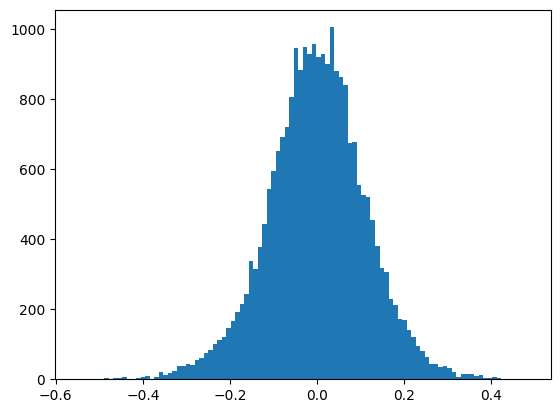

In [15]:
_ = plt.hist(cache["blocks.0.hook_resid_post"][0].flatten().cpu(), bins=100)

## finding neurons that activate on a certain feature

first, we need to come up with a feature and come up with some positive and negative examples

# SAEs

## set up the sparse autoencoder

In [ ]:
class SAE(torch.nn.Module):
	def __init__(self, d_model: int, d_hidden: int):
		super(SAE, self).__init__()
		self.encoder: torch.nn.Module = None # ...
		self.decoder: torch.nn.Module = None # ...

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		# ...
		pass

## set up the training loop

In [ ]:
def train_sae(
	model: HookedTransformer,
	dataset: list[str] = TEXT_DATA,
	batchsize: int = 32,
	epochs: int = 10,
	sae_hidden: int = 128,
	learning_rate: float = 1e-3,
):
	# ...
	pass

## find features which correspond to a sample of text